In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib

from IPython import display

In [14]:
class U_Net(Model):

    def __init__(self, in_dim, num_channels=2, emb_dim=512, gate_filters=32, num_resolutions=2, attn_res_idx=2):
        super().__init__()
        
        self.in_dim = in_dim
        self.num_channels = num_channels
        self.num_resolutions = num_resolutions
        self.attn_res_idx = attn_res_idx
        self.emb_dim = emb_dim
        self.gate_filters = gate_filters
        self.model = self.build_graph()
        
#     def timestep_embedding(self, ts, embedding_dim):
#         assert len(ts.shape)==1
        
#         half_dim = embedding_dim // 2
#         emb = -(tf.math.log(10000.0)/(half_dim-1))
        
#         idxs = tf.range(half_dim, dtype=tf.float32)
#         emb = tf.math.exp(idxs*emb)
        
#         ts = tf.cast(ts, dtype=tf.float32)
        
#         emb = ts[:,None]* emb[None,:]
        
#         pe = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
        
#         return pe
    
    def nonlinearity(self, x):
        return tf.keras.activations.swish(x)
    
    def normalize(self, x):
        return tfa.layers.InstanceNormalization(axis=-1)(x)
        
    def ResBlK(self, x, temb=None):
        h = self.nonlinearity(self.normalize(x))
        h = layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(h)
        if not temb == None:
            temb = self.nonlinearity(temb)
            h +=  tf.reshape(layers.Dense(h.shape[-1])(temb), (-1, 1, 1,h.shape[-1]))

        h = self.nonlinearity(self.normalize(h))
        h = layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        return x+h
        
    def downsample(self, x, filters, factor=2):
        return layers.Conv2D(filters, (3, 3),
                                        strides=(factor, factor), padding='same')(x)

    def upsample(self, x, filters, factor=2):
        return layers.Conv2DTranspose(filters, (3, 3),
                                       strides=(factor, factor), padding='same')(x)
        
    def NonlocalGaussian(self, x):
        h = self.normalize(x)
        theta = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        phi = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        g = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        phi = tf.transpose(phi, (0, 3, 2, 1))

        theta = tf.reshape(theta, shape=(-1, theta.shape[1]*theta.shape[2], theta.shape[3]))

        phi = tf.reshape(phi, shape=(-1, phi.shape[1], phi.shape[2]*phi.shape[3]))
        g = tf.reshape(g, shape=(-1, g.shape[1]*g.shape[2], g.shape[3]))
        
        f = tf.matmul(theta, phi)
        
        f = layers.Softmax()(f)
        
        y = tf.matmul(f, g)
        
        y = tf.reshape(y, (-1, x.shape[1], x.shape[2], y.shape[-1]))
        
        z = tf.math.add(x, layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(y))
        return z
    
    def design(self, img_input):
        
        
        hs = [layers.Conv2D(self.gate_filters, (1, 1),
                                        strides=(1, 1), padding='same')(img_input)]
        for i in range(self.num_resolutions):
            h = self.ResBlK(hs[-1])
            if i == self.attn_res_idx:
                h = self.NonlocalGaussian(h)
                
            if i != self.num_resolutions - 1:
                h = self.downsample(h, h.shape[-1]*2)
                
            hs.append(h)

        h = hs[-1]
        h = self.ResBlK(h)
        h = self.NonlocalGaussian(h)
        h = self.ResBlK(h)
                
        for i in reversed(range(self.num_resolutions)):
            h = h+hs[i]
            h = self.ResBlK(h)

            if i == self.attn_res_idx:
                h = self.NonlocalGaussian(h)
                
            if i != 0:
                h = self.upsample(h, h.shape[-1]//2)
        
                
        h = self.nonlinearity(self.normalize(h))
        
        h = layers.Conv2D(self.num_channels, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        
        return h
    
    def call(self, x, t):
        return self.model([x,t])
    
    def build_graph(self):
        x = layers.Input(shape=(self.in_dim[0],
                                        self.in_dim[1], self.num_channels))
        
        return Model(inputs=[x], outputs=self.design(x))
        

In [15]:
unet1=U_Net((30, 68))

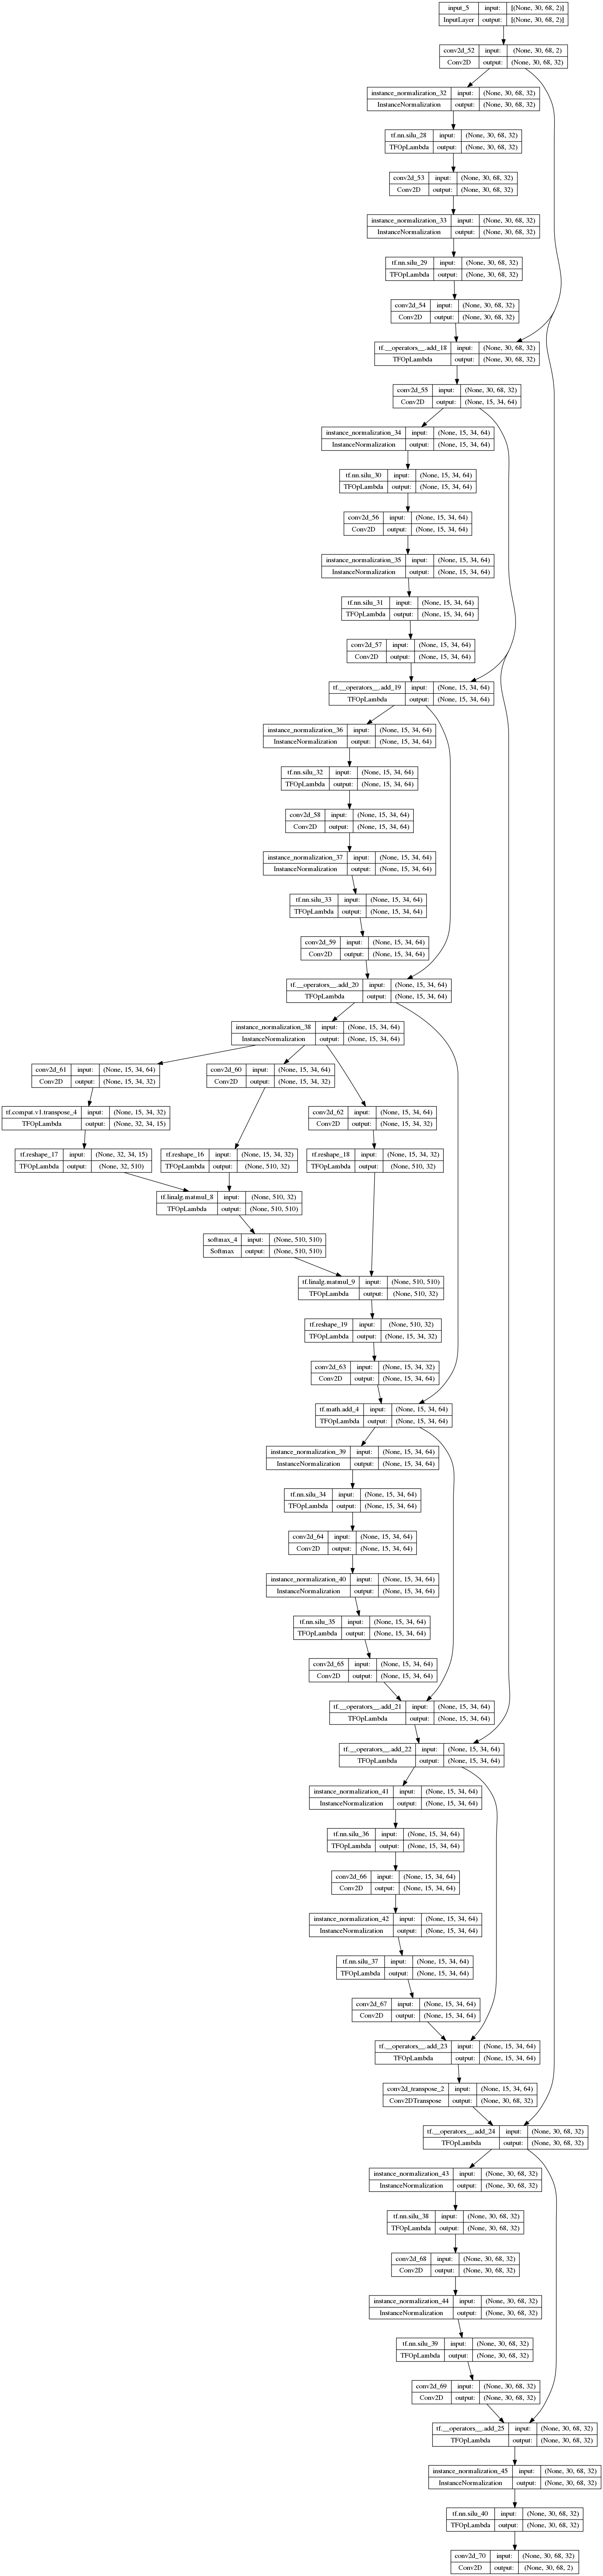

In [16]:
tf.keras.utils.plot_model(unet1.model, show_shapes=True)

In [17]:
unet1.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 30, 68, 2)]  0           []                               
                                                                                                  
 conv2d_52 (Conv2D)             (None, 30, 68, 32)   96          ['input_5[0][0]']                
                                                                                                  
 instance_normalization_32 (Ins  (None, 30, 68, 32)  64          ['conv2d_52[0][0]']              
 tanceNormalization)                                                                              
                                                                                                  
 tf.nn.silu_28 (TFOpLambda)     (None, 30, 68, 32)   0           ['instance_normalization_32[0

 tf.linalg.matmul_8 (TFOpLambda  (None, 510, 510)    0           ['tf.reshape_16[0][0]',          
 )                                                                'tf.reshape_17[0][0]']          
                                                                                                  
 conv2d_62 (Conv2D)             (None, 15, 34, 32)   2080        ['instance_normalization_38[0][0]
                                                                 ']                               
                                                                                                  
 softmax_4 (Softmax)            (None, 510, 510)     0           ['tf.linalg.matmul_8[0][0]']     
                                                                                                  
 tf.reshape_18 (TFOpLambda)     (None, 510, 32)      0           ['conv2d_62[0][0]']              
                                                                                                  
 tf.linalg

 tf.__operators__.add_25 (TFOpL  (None, 30, 68, 32)  0           ['tf.__operators__.add_24[0][0]',
 ambda)                                                           'conv2d_69[0][0]']              
                                                                                                  
 instance_normalization_45 (Ins  (None, 30, 68, 32)  64          ['tf.__operators__.add_25[0][0]']
 tanceNormalization)                                                                              
                                                                                                  
 tf.nn.silu_40 (TFOpLambda)     (None, 30, 68, 32)   0           ['instance_normalization_45[0][0]
                                                                 ']                               
                                                                                                  
 conv2d_70 (Conv2D)             (None, 30, 68, 2)    66          ['tf.nn.silu_40[0][0]']          
          